In [2]:
import os
import cv2
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
def scale_ycrcb(img_ycrcb):
    """
    Retorna una imagen escalada en (-128,128)
    """
    tem = np.zeros(img_ycrcb.shape, dtype=int)
    tem[:,:,0] = img_ycrcb[:,:,0]
    tem[:,:,1] = img_ycrcb[:,:,1] + (-128)
    tem[:,:,2] = img_ycrcb[:,:,2] + (-128)
    return tem

In [4]:
def arrowsimg(array_dydx, defacing = 0):
    """
    image_dydx: dydx Channels of an image (2D)
    defacing: If the reference map is defacing with respect to the YCrCb map
    return: magnitudes and angles of the arrows
    """
    #___________________________________________________________________________
    assert(array_dydx.ndim == 3), "The array is not 3D array"
    assert(array_dydx.shape[2] == 2), "Dimension is not valid (Channels)"
    #___________________________________________________________________________
    array_dydx = np.array(array_dydx)
    magnitudes, angles = cv2.cartToPolar(array_dydx[:,:,1].astype(float),
                                         array_dydx[:,:,0].astype(float),
                                         angleInDegrees=True)
    if defacing != 0:
        for row in range(angles.shape[0]):
            for col in range(angles.shape[1]):
                angle = angles[row,col]
                if (0.0 <= angle < 90.0 ): # first quadrant
                    angles[row,col] = angle + (360 - defacing)
                elif (90.0 <= angle < 180.0 ): # second quadrant
                    if defacing == 90:
                        angles[row,col] = angle - defacing
                    else:
                        angles[row,col] = angle + (360 - defacing)
                elif (180.0 <= angle < 270.0 ): # third quadrant
                    if defacing == 270:
                        angles[row,col] = angle + (360 - defacing)
                    else:
                        angles[row,col] = angle - defacing
                elif (270.0 <= angle <= 360.0 ): # fourth quadrant
                    angles[row,col] = angle - defacing

    return magnitudes, angles

In [5]:
def tao_(mag, ang, tao):
    x_n = []
    y_n = []
    magnitud = []
    angulo = []
    for fil in range(mag.shape[0]):
        for col in range(mag.shape[1]):
            if(mag[fil][col] > tao):
                x_n.append(col)
                y_n.append(fil)
                magnitud.append(mag[fil][col])
                angulo.append(ang[fil][col])
    return x_n, y_n, magnitud, angulo

In [6]:
def painting(his_n, bins, magnitud, angulo, i, x_n, y_n, a):
    #"""
    #Flechas
    plt.figure(figsize=(20,20))
    #plt.subplot(221), 
    plt.imshow(a)
    
    dx_n, dy_n = cv2.polarToCart(np.array(magnitud), np.array(angulo), angleInDegrees=True)
    plt.quiver(x_n[::2], y_n[::2], dx_n[::2,::2], dy_n[::2,::2], 
                   color = 'white', alpha = .8,
                   scale_units = 'xy',
                   angles = 'xy')
    plt.axis("off")
    if (i < 9):
        plt.savefig('/home/alejandra/HEART/Sunny_tesis/ARROWS/arrow00'+ str(i+1) +'.png')
    if (i >= 9):
        plt.savefig('/home/alejandra/HEART/Sunny_tesis/ARROWS/arrow0'+ str(i+1) +'.png')
    plt.close()
    
    """
    #Histogramas
    plt.figure(figsize=(15,4))
    #plt.subplot(222), }
    plt.bar(bins[:-1],his_n, 20, align='center', color='purple', edgecolor='black')
    #plt.subplot(223), plt.hist(magnitud, bins=100, width=0.4, color='purple')
    if (i < 9):
        plt.savefig('/home/alejandra/HEART/Sunny_tesis/MAGNI/0000'+ str(i+1) +'.png')
    if (i >= 9):
        plt.savefig('/home/alejandra/HEART/Sunny_tesis/MAGNI/000'+ str(i+1) +'.png')
    #"""

## PARA UNA CARPETA DE IMAGENES

In [7]:
#Dirección del path para encontrar la carpeta TRAIN, se puede usar en el TEST también y en DESCRIPTOR
training = 'final_approach'

In [11]:
def hist_mag(folder, n, name):
    c_final = []
    c_his = []
    dir_of = "/home/alejandra/HEART/Sunny_tesis/HEART/OF-PPM/"+folder+"/"+n+"/"
    print(dir_of)
    descriptor = open("/home/alejandra/HEART/Sunny_tesis/"+training+"/TRAIN/"+name, "a")
    
    image = [dir_of+imagen for imagen in os.listdir(dir_of)]
    separa = sorted(image,key = lambda x:int(x.split("/")[-1].split(".")[0]))

    for i, imagen in enumerate(separa):
        
        if(imagen != '/home/alejandra/HEART/Sunny_tesis/HEART/PPM/'+folder+'/'+n+'/000029.ppm'):    
            a = plt.imread(imagen)
            #c = plt.imread(c)
            img = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)

            imgsc = scale_ycrcb(img)[:,:,1:]
            mag, ang = arrowsimg(imgsc, 90)

            
            #Nota: no olvidar asignar en h_bins, bins el valor del ángulo y la magnitud.
            his_n, bins = np.histogram(ang, bins=12, range=[0,360], weights=mag)
            c_his = np.concatenate((c_his, his_n), axis =None)
            print(c_his)
            #Para pintar los valores: 
            print(x_n, y_n)
            painting(his_n, bins, magnitud, angulo, i, x_n, y_n, a)
            
    
    """
    NORMALIZACIÓN L1 - RAÍZ DE L1
    _____________________________
    """
    #c_his = c_his/np.sqrt(np.sum(c_his))
    #c_his = preprocessing.normalize(c_his.reshape(1, -1), norm='l1')
    #c_his = c_his[0]
    
    
    """
    NORMALIZACIÓN L2
    ________________
    """
    #c_his = c_his/np.sqrt(np.sum(c_his**2))
    #c_his = preprocessing.normalize(c_his.reshape(1, -1), norm='l2')
    #c_his = c_his[0]
    
    print(c_his.sum())
    c_final.append((c_his))
    print(c_final)
    
    #np.savetxt(descriptor, c_final)
    #descriptor.close()

## Descriptor global

#### Cambiar las direcciones

In [83]:
pri_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/an_pri_pat.txt", "r")
sec_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_sec_pat.txt", "r")
ter_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_ter_pat.txt", "r")
cua_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_cua_pat.txt", "r")

In [84]:
for i in pri_pat:
    print(i)
    hist_mag(i[:10], i[11], 'array_descriptor_final.txt')

for i in sec_pat:
    print(i)
    hist_mag(i[:11], i[12], 'array_descriptor_final.txt')

for i in ter_pat:
    print(i)
    hist_mag(i[:9], i[10], 'array_descriptor_final.txt')
    
for i in cua_pat:
    print(i)
    hist_mag(i[:7], i[8], 'array_descriptor_final.txt')

SC-HF-I-01 7

[ 2151.61080349  2315.82352211  2831.72579945  2787.87527306
  1710.33037034 10363.26726044 13387.49344758 19936.69180893
  7893.47429021  8040.25601051  9917.87094317  4934.03570567]
[ 2151.61080349  2315.82352211  2831.72579945  2787.87527306
  1710.33037034 10363.26726044 13387.49344758 19936.69180893
  7893.47429021  8040.25601051  9917.87094317  4934.03570567
  3660.8648565   3022.1083396   3320.22152148  3214.28110999
  2583.5340562   5033.31697396  8521.93685327 18454.94236467
  8543.02751423  8939.43478882 12823.70753796  7214.8805747 ]
[ 2151.61080349  2315.82352211  2831.72579945  2787.87527306
  1710.33037034 10363.26726044 13387.49344758 19936.69180893
  7893.47429021  8040.25601051  9917.87094317  4934.03570567
  3660.8648565   3022.1083396   3320.22152148  3214.28110999
  2583.5340562   5033.31697396  8521.93685327 18454.94236467
  8543.02751423  8939.43478882 12823.70753796  7214.8805747
  1941.68684666  4063.07166252  5458.73281022  9434.00188735
 22499.38

[2.15161080e+03 2.31582352e+03 2.83172580e+03 2.78787527e+03
 1.71033037e+03 1.03632673e+04 1.33874934e+04 1.99366918e+04
 7.89347429e+03 8.04025601e+03 9.91787094e+03 4.93403571e+03
 3.66086486e+03 3.02210834e+03 3.32022152e+03 3.21428111e+03
 2.58353406e+03 5.03331697e+03 8.52193685e+03 1.84549424e+04
 8.54302751e+03 8.93943479e+03 1.28237075e+04 7.21488057e+03
 1.94168685e+03 4.06307166e+03 5.45873281e+03 9.43400189e+03
 2.24993884e+04 2.31529932e+04 4.00023417e+04 1.36937676e+04
 3.59909948e+03 1.11619125e+03 8.65581652e+03 6.25910762e+03
 3.26963744e+03 3.13569427e+03 5.64495949e+03 8.92028159e+03
 3.60772365e+04 3.10339339e+04 2.44190931e+04 2.11727244e+04
 2.85224428e+03 1.49911233e+03 3.62618130e+03 4.09728140e+03
 4.05428904e+03 2.17052228e+03 7.30363028e+03 1.29487877e+04
 1.78345834e+04 2.15817851e+04 1.01231593e+04 2.02142645e+04
 2.19929750e+03 1.74566824e+03 2.87927861e+03 3.12670728e+03
 3.27646693e+03 2.75500319e+03 6.51796354e+03 9.02584440e+03
 5.05935009e+03 6.463005

[ 8472.66679273  6918.37109272  4108.98947582   940.85502661
  3810.55057262 12700.55260754 54722.28525254 19129.47033161
 20672.07857248  1909.8398934   1767.28320833  4323.51559889
  2775.68153419  5380.99384877  3874.70515071 10044.54481285
 23694.3399918  38871.6290617  53328.08950578 33579.54707461
 20038.08689649  2316.0548727   1762.14080195  1430.22036984
  1917.24137936  2950.01658687  6835.45054737  7652.86592399
 16346.61004469 45088.08185476 41612.74529796 46210.01543268
 18705.35507336  8472.36072982  1337.33399646  2670.25758087]
[ 8472.66679273  6918.37109272  4108.98947582   940.85502661
  3810.55057262 12700.55260754 54722.28525254 19129.47033161
 20672.07857248  1909.8398934   1767.28320833  4323.51559889
  2775.68153419  5380.99384877  3874.70515071 10044.54481285
 23694.3399918  38871.6290617  53328.08950578 33579.54707461
 20038.08689649  2316.0548727   1762.14080195  1430.22036984
  1917.24137936  2950.01658687  6835.45054737  7652.86592399
 16346.61004469 45088.0

[8.47266679e+03 6.91837109e+03 4.10898948e+03 9.40855027e+02
 3.81055057e+03 1.27005526e+04 5.47222853e+04 1.91294703e+04
 2.06720786e+04 1.90983989e+03 1.76728321e+03 4.32351560e+03
 2.77568153e+03 5.38099385e+03 3.87470515e+03 1.00445448e+04
 2.36943400e+04 3.88716291e+04 5.33280895e+04 3.35795471e+04
 2.00380869e+04 2.31605487e+03 1.76214080e+03 1.43022037e+03
 1.91724138e+03 2.95001659e+03 6.83545055e+03 7.65286592e+03
 1.63466100e+04 4.50880819e+04 4.16127453e+04 4.62100154e+04
 1.87053551e+04 8.47236073e+03 1.33733400e+03 2.67025758e+03
 2.11734701e+03 2.96985286e+03 5.85431866e+03 5.73462893e+03
 1.72571556e+04 3.15161723e+04 6.08580845e+04 3.39979941e+04
 2.16873793e+04 1.29586781e+03 1.18558120e+03 1.89166959e+03
 1.63202656e+03 4.50800654e+03 3.08418826e+03 7.65871242e+03
 2.06211916e+04 1.61144423e+04 3.35775974e+04 2.26128425e+04
 1.67165954e+04 3.00077004e+03 1.06370092e+03 1.95174079e+03
 7.57895296e+02 1.18178245e+03 2.38332649e+03 5.85973222e+03
 1.19147620e+04 2.673109

[1.00767467e+04 8.78639377e+03 3.15669203e+04 3.76213636e+04
 1.90823695e+04 1.23644972e+04 1.40828964e+04 2.94109682e+03
 6.15040762e+03 8.37699855e+03 1.83236293e+04 1.24918083e+04
 7.42473598e+03 1.18902897e+04 4.07892613e+04 5.63089024e+04
 2.88057537e+04 1.52220307e+04 2.09635771e+04 1.83282235e+04
 2.08924084e+04 5.68974454e+03 2.38166750e+04 1.05372894e+04
 5.46478172e+03 1.95751932e+04 1.95691261e+04 2.08720828e+04
 3.38920004e+04 3.65756381e+04 8.21908374e+04 3.02672513e+04
 3.65712409e+04 1.28633164e+04 1.24487212e+04 4.36394823e+03
 3.17833566e+03 1.15689815e+04 2.07025919e+04 1.54577939e+04
 3.30114056e+04 3.11872368e+04 8.40003439e+04 1.17167277e+04
 1.88509860e+04 4.78174539e+03 7.45512557e+03 2.67717716e+03
 2.04004204e+03 3.14070192e+03 9.69624639e+03 1.47577408e+04
 1.51786864e+04 3.10698227e+04 5.50142211e+04 2.40881477e+03
 1.21617349e+03 1.50710322e+03 6.39305691e+03 2.02681592e+03
 2.83232230e+02 4.32393231e+02 4.08080115e+02 6.61181436e+02
 7.94437214e+03 2.132299

[1.00767467e+04 8.78639377e+03 3.15669203e+04 3.76213636e+04
 1.90823695e+04 1.23644972e+04 1.40828964e+04 2.94109682e+03
 6.15040762e+03 8.37699855e+03 1.83236293e+04 1.24918083e+04
 7.42473598e+03 1.18902897e+04 4.07892613e+04 5.63089024e+04
 2.88057537e+04 1.52220307e+04 2.09635771e+04 1.83282235e+04
 2.08924084e+04 5.68974454e+03 2.38166750e+04 1.05372894e+04
 5.46478172e+03 1.95751932e+04 1.95691261e+04 2.08720828e+04
 3.38920004e+04 3.65756381e+04 8.21908374e+04 3.02672513e+04
 3.65712409e+04 1.28633164e+04 1.24487212e+04 4.36394823e+03
 3.17833566e+03 1.15689815e+04 2.07025919e+04 1.54577939e+04
 3.30114056e+04 3.11872368e+04 8.40003439e+04 1.17167277e+04
 1.88509860e+04 4.78174539e+03 7.45512557e+03 2.67717716e+03
 2.04004204e+03 3.14070192e+03 9.69624639e+03 1.47577408e+04
 1.51786864e+04 3.10698227e+04 5.50142211e+04 2.40881477e+03
 1.21617349e+03 1.50710322e+03 6.39305691e+03 2.02681592e+03
 2.83232230e+02 4.32393231e+02 4.08080115e+02 6.61181436e+02
 7.94437214e+03 2.132299

[  778.           183.84776311  2641.14973713   584.61953381
  1365.93366968  5460.68480436  8577.98227515  5719.1029386
 12384.12968175 19322.35914814  2324.62590826    35.77708764
   893.61636382    94.03826881   589.95878146  3777.87443414
  6969.27927505  1984.3329343   9019.97612672  8866.35259736
  9895.06848066 14268.8259412   4313.14298296  1063.37555285
   315.04039788   178.89108255   677.76042239 10178.81785001
  8519.31949302  8780.68603964 35485.48236807 19891.12749196
 20007.51222477  4617.48088586   526.64845848   124.00303721]
[7.78000000e+02 1.83847763e+02 2.64114974e+03 5.84619534e+02
 1.36593367e+03 5.46068480e+03 8.57798228e+03 5.71910294e+03
 1.23841297e+04 1.93223591e+04 2.32462591e+03 3.57770876e+01
 8.93616364e+02 9.40382688e+01 5.89958781e+02 3.77787443e+03
 6.96927928e+03 1.98433293e+03 9.01997613e+03 8.86635260e+03
 9.89506848e+03 1.42688259e+04 4.31314298e+03 1.06337555e+03
 3.15040398e+02 1.78891083e+02 6.77760422e+02 1.01788179e+04
 8.51931949e+03 8.780686

[7.78000000e+02 1.83847763e+02 2.64114974e+03 5.84619534e+02
 1.36593367e+03 5.46068480e+03 8.57798228e+03 5.71910294e+03
 1.23841297e+04 1.93223591e+04 2.32462591e+03 3.57770876e+01
 8.93616364e+02 9.40382688e+01 5.89958781e+02 3.77787443e+03
 6.96927928e+03 1.98433293e+03 9.01997613e+03 8.86635260e+03
 9.89506848e+03 1.42688259e+04 4.31314298e+03 1.06337555e+03
 3.15040398e+02 1.78891083e+02 6.77760422e+02 1.01788179e+04
 8.51931949e+03 8.78068604e+03 3.54854824e+04 1.98911275e+04
 2.00075122e+04 4.61748089e+03 5.26648458e+02 1.24003037e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.48874059e+02
 1.83762319e+04 1.90532190e+04 7.31935019e+04 3.63142598e+04
 1.00516334e+04 2.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77153373e+02
 9.86645765e+03 1.10275542e+04 6.53544613e+04 2.32446705e+04
 1.03624358e+04 6.30000000e+01 0.00000000e+00 0.00000000e+00
 1.10000000e+01 0.00000000e+00 0.00000000e+00 2.65606798e+02
 2.99871526e+03 5.475073

[1.58706908e+04 1.39445758e+03 1.11846238e+03 1.17794523e+03
 1.31020910e+04 1.93457533e+03 4.75861654e+03 1.74693965e+02
 1.71062199e+02 8.91964228e+02 4.09806026e+04 1.55856338e+04
 1.94428375e+03 5.81288574e+02 6.00199883e+03 4.57935068e+03
 1.75907603e+04 2.04661614e+04 1.20333263e+04 1.07985183e+04
 1.78333098e+04 5.03614868e+03 1.03490166e+04 3.12096940e+03
 1.64325546e+03 2.95574254e+03 1.77433553e+04 2.16541315e+04
 1.96567006e+04 5.09651959e+04 3.79159064e+04 2.99247944e+04
 1.41378082e+04 1.68394007e+03 2.31490600e+03 2.71023538e+03
 1.00796745e+03 1.66639279e+03 2.02031766e+04 2.03200167e+04
 2.26795103e+04 4.23678948e+04 2.92560411e+04 2.13624793e+04
 7.29343399e+03 1.70424998e+03 1.18181327e+03 2.10656917e+03
 1.33382369e+03 3.74287372e+03 1.20769965e+04 1.47294006e+04
 1.16424575e+04 2.54970270e+04 1.10789375e+04 1.28470155e+04
 5.68314913e+03 7.41991613e+02 2.65322693e+03 1.88333801e+03
 0.00000000e+00 2.82842712e+00 0.00000000e+00 5.59380121e+02
 8.65799426e+03 2.121985

[  219.70246875  4031.71940714  2494.69219227 11274.06915876
  4355.31047129  2822.63940032  3722.95565344   871.9678785
  4055.98025278  3607.40018513  8155.33853449  1021.00234339]
[  219.70246875  4031.71940714  2494.69219227 11274.06915876
  4355.31047129  2822.63940032  3722.95565344   871.9678785
  4055.98025278  3607.40018513  8155.33853449  1021.00234339
  4204.8174056   8515.12044917  7617.11733449 18728.60188772
  5377.39126929  4345.04714311   998.22815505   343.67085476
  9633.86275352  3628.83349657  7721.33274453  6985.09307725]
[  219.70246875  4031.71940714  2494.69219227 11274.06915876
  4355.31047129  2822.63940032  3722.95565344   871.9678785
  4055.98025278  3607.40018513  8155.33853449  1021.00234339
  4204.8174056   8515.12044917  7617.11733449 18728.60188772
  5377.39126929  4345.04714311   998.22815505   343.67085476
  9633.86275352  3628.83349657  7721.33274453  6985.09307725
  4730.01280446  3761.80548151 10650.40748795  6186.58081054
  9162.83111002  2300.552

[2.19702469e+02 4.03171941e+03 2.49469219e+03 1.12740692e+04
 4.35531047e+03 2.82263940e+03 3.72295565e+03 8.71967878e+02
 4.05598025e+03 3.60740019e+03 8.15533853e+03 1.02100234e+03
 4.20481741e+03 8.51512045e+03 7.61711733e+03 1.87286019e+04
 5.37739127e+03 4.34504714e+03 9.98228155e+02 3.43670855e+02
 9.63386275e+03 3.62883350e+03 7.72133274e+03 6.98509308e+03
 4.73001280e+03 3.76180548e+03 1.06504075e+04 6.18658081e+03
 9.16283111e+03 2.30055230e+03 4.10045459e+02 2.08534092e+02
 1.04152807e+04 1.04274791e+04 2.09882091e+04 1.30474415e+04
 4.42190291e+03 1.54058010e+03 6.99994728e+03 5.56449177e+03
 7.77567710e+03 4.17336425e+03 6.97014993e+03 1.66428828e+04
 9.48816566e+03 9.47319348e+03 1.72104834e+04 6.53064995e+03
 1.47275056e+03 1.30511474e+03 3.43123568e+03 4.86151019e+03
 6.27158245e+03 5.31168393e+03 2.24387693e+04 2.45747667e+04
 1.64810320e+04 1.35497279e+04 1.37084656e+04 2.34314868e+03
 9.36757024e+02 1.14714654e+03 1.64513128e+03 3.96596535e+03
 3.30119987e+03 2.851611

[8.96514278e+02 6.61083887e+02 3.76365339e+03 5.94776315e+03
 5.82881261e+03 1.04981073e+03 2.46824219e+04 3.02301213e+04
 4.63458946e+04 6.49387332e+03 2.89267111e+03 1.22526165e+03
 1.45328179e+03 2.01304958e+03 9.74977800e+02 2.67684940e+03
 1.94866140e+03 5.06754116e+01 1.22301333e+04 7.31288607e+04
 1.41649760e+04 3.32579309e+03 3.78939461e+03 1.72106087e+03]
[8.96514278e+02 6.61083887e+02 3.76365339e+03 5.94776315e+03
 5.82881261e+03 1.04981073e+03 2.46824219e+04 3.02301213e+04
 4.63458946e+04 6.49387332e+03 2.89267111e+03 1.22526165e+03
 1.45328179e+03 2.01304958e+03 9.74977800e+02 2.67684940e+03
 1.94866140e+03 5.06754116e+01 1.22301333e+04 7.31288607e+04
 1.41649760e+04 3.32579309e+03 3.78939461e+03 1.72106087e+03
 7.72130110e+02 1.59201610e+03 2.85437936e+03 3.52192218e+03
 4.17234233e+03 1.28153684e+04 3.03871273e+04 4.57458215e+04
 7.98494457e+03 3.34341157e+03 3.66551235e+03 6.28307988e+02]
[8.96514278e+02 6.61083887e+02 3.76365339e+03 5.94776315e+03
 5.82881261e+03 1.0498

[14850.18509777  5509.42220575 12693.11022944 28464.36852137
 17741.79449466 18183.42642138 13471.81798408  1409.35098151
  2215.88514628 20721.2208758  17194.93778502 14997.76498515]
[14850.18509777  5509.42220575 12693.11022944 28464.36852137
 17741.79449466 18183.42642138 13471.81798408  1409.35098151
  2215.88514628 20721.2208758  17194.93778502 14997.76498515
 13648.77953999 12730.98226869 35037.05376391 36037.62299191
 16145.06923575 11919.23701733 13610.65800442  8717.64977974
 17571.10732032 11817.64311817 41865.84196626  6920.76758291]
[14850.18509777  5509.42220575 12693.11022944 28464.36852137
 17741.79449466 18183.42642138 13471.81798408  1409.35098151
  2215.88514628 20721.2208758  17194.93778502 14997.76498515
 13648.77953999 12730.98226869 35037.05376391 36037.62299191
 16145.06923575 11919.23701733 13610.65800442  8717.64977974
 17571.10732032 11817.64311817 41865.84196626  6920.76758291
 21139.48314921 16032.99348572 36123.01482785 39353.96608893
 24796.44840515 14390.

[14850.18509777  5509.42220575 12693.11022944 28464.36852137
 17741.79449466 18183.42642138 13471.81798408  1409.35098151
  2215.88514628 20721.2208758  17194.93778502 14997.76498515
 13648.77953999 12730.98226869 35037.05376391 36037.62299191
 16145.06923575 11919.23701733 13610.65800442  8717.64977974
 17571.10732032 11817.64311817 41865.84196626  6920.76758291
 21139.48314921 16032.99348572 36123.01482785 39353.96608893
 24796.44840515 14390.26866168 29937.96502237 38998.19366639
 38255.68316903 25081.66174945 29358.24763382 16093.20455425
 11690.47610098 11306.81781781 42051.09770456 24645.93333561
 39542.55132793 11952.77525487 24569.26850899 31117.32851248
 31332.6466103  22744.48360165 17660.83746831 10894.57826224
  8590.95040082  6667.8219493  12803.46684919 20237.84950619
  9098.82046518  8822.92250019  9740.41990793  3774.36211983
 17113.96314375  5870.44290171 25619.52589053 17362.63189329
  7698.65962361  5450.03758572  6126.08496729 10037.83806677
  4129.46004338  5092.61

[  928.68048613  4581.5459157   9656.25786107  7868.12294705
 44845.84155336  9083.2591093   4627.96223592  4471.06078556
  1127.82317508   674.6075056   2873.03972236  1925.69335385
  7294.71612739  5079.86184678 11953.22283788 24250.49781444
 12300.04613375  5088.16375742  5026.63757806  3239.95999441
 18264.39946969  6009.80605294 16549.16811327  8471.44426825
  4484.2106014   3438.20913952 11029.12963208 12264.52991529
 18610.02972844 12449.39913042 51246.23084926 19424.51217498
 19187.416359   11924.07919663 10415.5728694   5398.55907418]
[  928.68048613  4581.5459157   9656.25786107  7868.12294705
 44845.84155336  9083.2591093   4627.96223592  4471.06078556
  1127.82317508   674.6075056   2873.03972236  1925.69335385
  7294.71612739  5079.86184678 11953.22283788 24250.49781444
 12300.04613375  5088.16375742  5026.63757806  3239.95999441
 18264.39946969  6009.80605294 16549.16811327  8471.44426825
  4484.2106014   3438.20913952 11029.12963208 12264.52991529
 18610.02972844 12449.3

[17569.8731516  16129.63976626 33380.66556313 14958.83823514
 14684.82047362  6618.33649164  5607.04400787  4084.18700821
  7495.63843803 21671.9345529  28547.78477693 13366.26541217
 29404.71562759 19107.38768471 17707.41935727 22657.65486833
 28020.00945549 26755.9202489   5828.29421333  8264.98192559
 16440.54598835 28637.02986081 35836.47430179  4597.20378849
 11948.28346709 11434.09568197  9430.50913774 23494.43454069
 13574.43548354 25152.05245348 16447.33814893 40555.70426493
 32198.34323071 25980.74913279  8986.20599063 13973.61156046]
[17569.8731516  16129.63976626 33380.66556313 14958.83823514
 14684.82047362  6618.33649164  5607.04400787  4084.18700821
  7495.63843803 21671.9345529  28547.78477693 13366.26541217
 29404.71562759 19107.38768471 17707.41935727 22657.65486833
 28020.00945549 26755.9202489   5828.29421333  8264.98192559
 16440.54598835 28637.02986081 35836.47430179  4597.20378849
 11948.28346709 11434.09568197  9430.50913774 23494.43454069
 13574.43548354 25152.0

[ 2693.60606042  4298.22024461 11808.28744549 12719.08892575
 18603.72949399 12216.85152718    55.28352426 15021.58079007
  6598.92030321  2475.87739887  5633.32765511  7493.23683915
  2566.72078754  3740.29590705 14562.28752621  5561.46109787
 15427.49423505 16003.23640741  6413.70951017   449.93276179
  5095.5480915  18601.57796699 32832.4235867   3718.02587258]
[ 2693.60606042  4298.22024461 11808.28744549 12719.08892575
 18603.72949399 12216.85152718    55.28352426 15021.58079007
  6598.92030321  2475.87739887  5633.32765511  7493.23683915
  2566.72078754  3740.29590705 14562.28752621  5561.46109787
 15427.49423505 16003.23640741  6413.70951017   449.93276179
  5095.5480915  18601.57796699 32832.4235867   3718.02587258
  2087.98318749  4711.55185313  5704.7553851  13013.14441551
 15599.89727495 18853.68845635 36287.30683776 15558.8742875
 18922.22604124 18679.94789486 10259.84626471  3018.90643364]
[2.69360606e+03 4.29822024e+03 1.18082874e+04 1.27190889e+04
 1.86037295e+04 1.22168

[2.69360606e+03 4.29822024e+03 1.18082874e+04 1.27190889e+04
 1.86037295e+04 1.22168515e+04 5.52835243e+01 1.50215808e+04
 6.59892030e+03 2.47587740e+03 5.63332766e+03 7.49323684e+03
 2.56672079e+03 3.74029591e+03 1.45622875e+04 5.56146110e+03
 1.54274942e+04 1.60032364e+04 6.41370951e+03 4.49932762e+02
 5.09554809e+03 1.86015780e+04 3.28324236e+04 3.71802587e+03
 2.08798319e+03 4.71155185e+03 5.70475539e+03 1.30131444e+04
 1.55998973e+04 1.88536885e+04 3.62873068e+04 1.55588743e+04
 1.89222260e+04 1.86799479e+04 1.02598463e+04 3.01890643e+03
 1.61952290e+03 2.60416147e+03 1.03942677e+04 1.00853731e+04
 1.23693340e+04 1.69442928e+04 5.89111100e+04 3.04285217e+04
 1.51376695e+04 1.12404377e+04 5.87399733e+03 1.77376257e+03
 2.13637519e+03 1.97932801e+03 4.93113798e+03 2.43778085e+03
 1.67242003e+04 1.94696278e+04 4.31532861e+04 2.73427062e+04
 1.58653247e+04 9.93288346e+03 4.33907149e+03 1.97543308e+03
 1.15930719e+03 2.64202765e+03 1.96217542e+03 2.79060685e+03
 8.95463552e+03 2.857670

[ 3520.07600412 10481.39344673 12774.67653943 11580.1467705
  7738.47242319  2532.02997591   786.36741274 11752.95323045
 15544.61652191  5910.69157568 18644.00680763  1981.95212271
 38582.59095024  8049.64023908  8507.92651738  6556.61245967
  4842.53945088  2136.52283843  4774.97146297 21200.81188028
 23580.33388887  9250.15350323 45567.43335419 27162.74001646
 16707.63813821 14023.93805599 11916.29785862  3702.30422052
  7432.21253689  2351.67321253 29256.38581179 29541.0103126
 36505.9881147  52927.80556238 44014.46430274 16697.67520179
  9223.67881417 15059.25140029  3915.37290647  1633.24626882
  1957.06420837  5972.99913984 33547.95193847 15333.13706263
 49807.60468093 50215.66739916 45561.54867969 18850.8288854
  8257.96580716 10957.71702228  6838.10442305  2466.79701651
  2523.26390095  5875.72817703 16431.99433863 20961.22496924
 30350.09215485 41883.2403695  33195.83528381 11075.24866788
  5553.93242133  7262.29336614  6418.14710656  1426.95464403
  2701.1637299  10110.66584

[3.52007600e+03 1.04813934e+04 1.27746765e+04 1.15801468e+04
 7.73847242e+03 2.53202998e+03 7.86367413e+02 1.17529532e+04
 1.55446165e+04 5.91069158e+03 1.86440068e+04 1.98195212e+03
 3.85825910e+04 8.04964024e+03 8.50792652e+03 6.55661246e+03
 4.84253945e+03 2.13652284e+03 4.77497146e+03 2.12008119e+04
 2.35803339e+04 9.25015350e+03 4.55674334e+04 2.71627400e+04
 1.67076381e+04 1.40239381e+04 1.19162979e+04 3.70230422e+03
 7.43221254e+03 2.35167321e+03 2.92563858e+04 2.95410103e+04
 3.65059881e+04 5.29278056e+04 4.40144643e+04 1.66976752e+04
 9.22367881e+03 1.50592514e+04 3.91537291e+03 1.63324627e+03
 1.95706421e+03 5.97299914e+03 3.35479519e+04 1.53331371e+04
 4.98076047e+04 5.02156674e+04 4.55615487e+04 1.88508289e+04
 8.25796581e+03 1.09577170e+04 6.83810442e+03 2.46679702e+03
 2.52326390e+03 5.87572818e+03 1.64319943e+04 2.09612250e+04
 3.03500922e+04 4.18832404e+04 3.31958353e+04 1.10752487e+04
 5.55393242e+03 7.26229337e+03 6.41814711e+03 1.42695464e+03
 2.70116373e+03 1.011066

[8.96422938e+02 1.02578512e+04 1.09856183e+04 2.36646815e+04
 5.13674587e+04 6.25128412e+03 2.63634816e+03 6.65693676e+03
 1.96270944e+04 8.72523159e+03 4.22879004e+03 6.24197855e+01
 2.85254483e+03 5.17092207e+03 5.21924626e+04 1.99518541e+04
 1.68023660e+04 3.45543724e+03 3.94343447e+03 8.50558745e+03
 2.95165983e+04 2.34369962e+04 1.92034303e+04 1.46526238e+04
 3.46412191e+03 6.25831074e+03 1.35705387e+04 5.19582750e+03
 9.57989504e+03 2.71365140e+04 1.80583979e+04 1.03866151e+04
 4.48349402e+04 2.21902307e+04 1.49599357e+04 2.17142053e+04
 2.40398507e+03 4.60594869e+03 1.10286318e+04 5.21000578e+03
 7.33291483e+03 2.14186751e+04 4.04282724e+04 1.41826817e+04
 5.35851399e+04 1.47756328e+04 2.59732355e+04 1.41649591e+03
 4.15549567e+03 1.96541955e+03 5.74723995e+03 1.81247115e+03
 3.80962172e+03 1.74559606e+04 3.13513752e+04 1.53433328e+04
 3.62090752e+04 1.50465655e+04 9.65350434e+03 5.00548655e+03
 1.00295518e+03 7.20777792e+02 5.78043132e+02 3.46463614e+02
 5.10976071e+02 1.166905

[8.96422938e+02 1.02578512e+04 1.09856183e+04 2.36646815e+04
 5.13674587e+04 6.25128412e+03 2.63634816e+03 6.65693676e+03
 1.96270944e+04 8.72523159e+03 4.22879004e+03 6.24197855e+01
 2.85254483e+03 5.17092207e+03 5.21924626e+04 1.99518541e+04
 1.68023660e+04 3.45543724e+03 3.94343447e+03 8.50558745e+03
 2.95165983e+04 2.34369962e+04 1.92034303e+04 1.46526238e+04
 3.46412191e+03 6.25831074e+03 1.35705387e+04 5.19582750e+03
 9.57989504e+03 2.71365140e+04 1.80583979e+04 1.03866151e+04
 4.48349402e+04 2.21902307e+04 1.49599357e+04 2.17142053e+04
 2.40398507e+03 4.60594869e+03 1.10286318e+04 5.21000578e+03
 7.33291483e+03 2.14186751e+04 4.04282724e+04 1.41826817e+04
 5.35851399e+04 1.47756328e+04 2.59732355e+04 1.41649591e+03
 4.15549567e+03 1.96541955e+03 5.74723995e+03 1.81247115e+03
 3.80962172e+03 1.74559606e+04 3.13513752e+04 1.53433328e+04
 3.62090752e+04 1.50465655e+04 9.65350434e+03 5.00548655e+03
 1.00295518e+03 7.20777792e+02 5.78043132e+02 3.46463614e+02
 5.10976071e+02 1.166905

[1.42764249e+04 7.20656201e+03 3.62309633e+03 1.31041935e+04
 5.47256154e+03 3.72955657e+03 8.44839269e+02 9.63248258e+02
 8.16264143e+03 1.01671638e+04 8.38927554e+03 5.89569188e+03
 4.50599245e+03 2.23020709e+04 3.01550384e+04 2.60845158e+04
 1.08799765e+04 7.05023779e+02 6.32914159e+03 9.66777011e+03
 1.62540033e+04 2.10303952e+04 2.64131209e+03 2.05738973e+03
 6.58078539e+03 9.73919977e+03 4.41415673e+04 3.61703802e+04
 7.10076521e+03 9.05061322e+02 7.01680603e+03 2.42990101e+04
 2.91754175e+04 1.91544062e+04 1.06242830e+04 3.62193918e+03
 7.11339013e+03 7.78370930e+03 2.05898829e+04 2.04207040e+04
 2.45074150e+04 5.18576603e+03 2.11723314e+04 2.41798692e+04
 2.59296651e+04 2.00968990e+04 9.55528521e+03 3.62188959e+03
 3.81769642e+03 5.04542404e+03 9.40406796e+03 8.67149527e+03
 1.08757590e+04 1.50775997e+04 2.21639452e+04 2.57330917e+04
 1.41827855e+04 1.51875310e+04 6.92168926e+03 2.66035597e+03
 2.29978199e+03 2.89385123e+03 5.43058456e+03 5.22843628e+03
 7.95189814e+03 1.545784

[ 7152.94864767  1880.74786669  5240.80054597  1785.
  1278.02357635  4570.40899916 42237.70117337 23710.01010642
  1728.89324686  1962.92081517  4873.85522109  4030.67848957
  3019.31227737  5826.89165271  3307.1166415   8324.49181169
  8871.1136305   3533.05997123 74342.60876822 23384.75327592
  3484.85004286  1047.31369596   897.29414394  1891.90807641
   697.46873769  2373.11078371  6463.75103716 13191.02978855
 17433.32147092 21709.25101905 78018.96647296 21927.12945975
  8439.3993113   4526.40900621  3142.51865896  1589.03936019
  1165.07436214  1418.16947014  8146.96289136 11638.16146817
 18103.91883418 32134.56296812 60373.70123868 30582.08371737
  8030.22337964  2884.10405365  6186.05210104  1437.48162211
  1874.87454189  3192.67589712  6426.66070321  3988.80310879
  8584.73996446 21834.4541973  42976.84725849 20989.11512963
  4960.40920367  2775.34030688  2395.15103323  1303.55324465
  1060.95095671  1169.40071517  1241.33816987  1729.22396884
  6501.94155627 12747.86075174 2

[ 1644.31433009  1397.3440933   7283.10356016  9220.46294652
 29231.39499914  1895.04057377   108.85274942   894.57161765
  3778.35621642  3872.01694582 19979.40585502  3395.14642961]
[ 1644.31433009  1397.3440933   7283.10356016  9220.46294652
 29231.39499914  1895.04057377   108.85274942   894.57161765
  3778.35621642  3872.01694582 19979.40585502  3395.14642961
 10320.02506885 11448.74627073 32735.56250749 30089.17714231
 10460.22058908  1808.23287007  5426.60265553  2306.694655
 16295.6501259   8414.7881742  19150.03451141 17605.11269667]
[ 1644.31433009  1397.3440933   7283.10356016  9220.46294652
 29231.39499914  1895.04057377   108.85274942   894.57161765
  3778.35621642  3872.01694582 19979.40585502  3395.14642961
 10320.02506885 11448.74627073 32735.56250749 30089.17714231
 10460.22058908  1808.23287007  5426.60265553  2306.694655
 16295.6501259   8414.7881742  19150.03451141 17605.11269667
 11513.41991015 11774.10613175 42332.61424376 22653.98699408
 17172.17213786 15502.1046

[ 1644.31433009  1397.3440933   7283.10356016  9220.46294652
 29231.39499914  1895.04057377   108.85274942   894.57161765
  3778.35621642  3872.01694582 19979.40585502  3395.14642961
 10320.02506885 11448.74627073 32735.56250749 30089.17714231
 10460.22058908  1808.23287007  5426.60265553  2306.694655
 16295.6501259   8414.7881742  19150.03451141 17605.11269667
 11513.41991015 11774.10613175 42332.61424376 22653.98699408
 17172.17213786 15502.10461923 11764.93579258 17030.5302306
 15061.32882284 12071.41454195 48851.96990583 14121.34110755
  7949.15393554  7623.97357894 26062.6294948  17386.9434833
 10271.88687269 24880.55675431 21433.84673065 11439.92056988
 13464.05162804 14151.20020853 40309.0517778  12154.76760995
  7800.14960146  6807.42415151 16010.92908714 20341.85721464
 12621.25908729 11930.75984609  7956.46341813  9929.85482856
 13609.24923331 15325.11546906 52929.43519042 12690.7157255
  6616.56274332  4688.56144524 19012.78754717 10901.00553766
  7785.30714637  9919.5473123

[6.51485747e+03 3.60911395e+03 2.49695327e+04 1.08782880e+04
 6.87219206e+03 3.35823099e+03 7.63352582e+03 8.01986430e+03
 5.42234591e+02 9.81708204e+02 1.68635129e+02 1.46896545e+03
 4.07913015e+03 3.65811083e+03 2.49639325e+04 9.55092726e+03
 1.34647712e+04 2.53049298e+04 1.50547944e+04 1.23398646e+04
 3.01355680e+03 2.99840596e+03 6.56021500e+02 1.19931027e+03
 4.65973961e+03 2.40877990e+03 1.97205969e+04 8.77767238e+03
 1.32505783e+04 3.98885917e+04 2.52976961e+04 7.36479927e+03
 4.93174008e+03 1.31601208e+03 1.22832263e+03 2.14580620e+03
 4.02235810e+03 2.41435783e+03 1.96845432e+04 8.99033834e+03
 1.29500657e+04 3.73864887e+04 1.97872315e+04 5.99157884e+03
 4.85718212e+03 1.12802206e+03 2.51653606e+03 2.45673057e+03
 2.36840970e+03 9.84897936e+02 1.30420996e+04 4.37157844e+03
 1.17514950e+04 1.90916514e+04 2.28343164e+04 1.11689261e+04
 3.35295526e+03 1.15349923e+03 3.84721084e+03 2.67465066e+03
 1.11682611e+03 6.92931015e+02 2.07792034e+02 1.65300444e+03
 9.42677515e+03 1.168375

[0.00000000e+00 5.65685425e+00 1.55158636e+03 4.10525682e+03
 1.24043103e+04 1.99567307e+04 1.12922562e+04 9.72543509e+02
 6.89565709e+02 5.20000000e+01 0.00000000e+00 0.00000000e+00
 8.92051802e+01 3.71301077e+02 5.25292732e+01 3.51678633e+02
 5.89515652e+02 4.81316392e+03 1.75980718e+04 2.37496559e+04
 1.03136518e+04 2.96440032e+04 5.42107747e+03 4.40232989e+01
 9.91477412e+01 1.02074689e+02 1.15228053e+03 2.21690154e+02
 1.80901964e+03 1.27944578e+04 3.99247460e+03 3.33332800e+04
 1.68515914e+04 4.79335056e+04 1.58218430e+04 3.39182234e+02]
[0.00000000e+00 5.65685425e+00 1.55158636e+03 4.10525682e+03
 1.24043103e+04 1.99567307e+04 1.12922562e+04 9.72543509e+02
 6.89565709e+02 5.20000000e+01 0.00000000e+00 0.00000000e+00
 8.92051802e+01 3.71301077e+02 5.25292732e+01 3.51678633e+02
 5.89515652e+02 4.81316392e+03 1.75980718e+04 2.37496559e+04
 1.03136518e+04 2.96440032e+04 5.42107747e+03 4.40232989e+01
 9.91477412e+01 1.02074689e+02 1.15228053e+03 2.21690154e+02
 1.80901964e+03 1.27944

[  746.05144383  1521.98948761 15135.98138746  8522.38523864
  7555.03367989  2766.03726548   668.46468615  1324.83900717
 13650.20912283 16246.14075409 10340.36859589  1009.03658338
  1695.28717357  9544.08579146  7044.38834335  4319.8877049
 15546.70081621 22878.07091175 29294.49710213 20747.12428478
 20454.76155553  3638.58762578  2477.90246194   933.62073861
   459.6047795   1327.94914382 11205.45742091  8147.96840118
 18815.80714728 45909.67718136 41522.82251537 28142.88924612
  7293.14879493  3222.63035022  2382.10777442  2862.64895733]
[  746.05144383  1521.98948761 15135.98138746  8522.38523864
  7555.03367989  2766.03726548   668.46468615  1324.83900717
 13650.20912283 16246.14075409 10340.36859589  1009.03658338
  1695.28717357  9544.08579146  7044.38834335  4319.8877049
 15546.70081621 22878.07091175 29294.49710213 20747.12428478
 20454.76155553  3638.58762578  2477.90246194   933.62073861
   459.6047795   1327.94914382 11205.45742091  8147.96840118
 18815.80714728 45909.677

[7.46051444e+02 1.52198949e+03 1.51359814e+04 8.52238524e+03
 7.55503368e+03 2.76603727e+03 6.68464686e+02 1.32483901e+03
 1.36502091e+04 1.62461408e+04 1.03403686e+04 1.00903658e+03
 1.69528717e+03 9.54408579e+03 7.04438834e+03 4.31988770e+03
 1.55467008e+04 2.28780709e+04 2.92944971e+04 2.07471243e+04
 2.04547616e+04 3.63858763e+03 2.47790246e+03 9.33620739e+02
 4.59604779e+02 1.32794914e+03 1.12054574e+04 8.14796840e+03
 1.88158071e+04 4.59096772e+04 4.15228225e+04 2.81428892e+04
 7.29314879e+03 3.22263035e+03 2.38210777e+03 2.86264896e+03
 1.10427363e+03 9.79158601e+02 4.70718518e+03 1.03476232e+04
 3.41894434e+04 5.16558487e+04 4.02909971e+04 2.67170510e+04
 6.70936815e+03 3.17150665e+03 1.41221082e+03 1.73477518e+03
 1.30281064e+03 1.73999967e+02 2.74938980e+03 5.43215726e+03
 1.52110119e+04 3.81079866e+04 3.69672784e+04 1.81009309e+04
 4.59490816e+03 8.18499428e+02 1.77999628e+03 5.78749102e+02
 8.40000000e+01 7.07106781e+00 0.00000000e+00 3.06000000e+02
 2.84243060e+01 2.161633

[1.85864868e+03 6.81149921e+03 2.66623954e+04 1.44664871e+04
 1.39460337e+04 6.11130463e+03 4.75514872e+03 2.31661141e+03
 4.30730548e+03 2.04044823e+03 6.75466542e+03 2.61669712e+03
 7.44306468e+03 4.34361445e+03 7.13900806e+03 2.05396193e+04
 1.15185869e+04 8.37518355e+03 2.10037301e+04 4.97668512e+04
 2.60590630e+04 1.96806872e+04 1.08310584e+04 5.69621766e+03
 6.06664435e+03 9.19353014e+03 5.10391296e+03 8.37554348e+03
 5.16163132e+03 1.75665813e+04 9.29626120e+03 3.20429949e+04
 3.00773823e+04 1.55809264e+04 3.32547205e+04 1.32907906e+04
 5.45020308e+03 2.78123740e+03 7.24253850e+03 2.53792841e+03
 1.14326713e+04 5.06451851e+03 8.94309417e+03 1.56483627e+04
 1.29933310e+04 8.91800434e+03 3.12194896e+04 1.98010352e+04
 2.00585545e+03 7.11874279e+02 3.29874127e+02 5.66824507e+02
 1.26466976e+03 3.32728397e+03 4.77609226e+03 3.15646695e+03
 1.08416705e+04 4.13322332e+03 5.90491540e+03 1.68616302e+04
 1.23637053e+03 2.69301051e+02 4.76072563e+01 6.90508215e+01
 3.28109776e+03 4.293667

[1.18180413e+04 7.16407435e+03 9.47782183e+03 1.98205459e+04
 2.20834205e+04 2.00006499e+04 7.16703267e+03 2.00358380e+04
 9.21565056e+03 1.70338396e+03 2.00901387e+03 2.76375631e+03
 1.39865236e+03 1.86521188e+03 5.78192004e+03 4.57430035e+03
 1.98675077e+04 4.89215262e+04 3.19801138e+04 3.95607355e+04
 2.40454177e+04 2.38279969e+04 2.63138159e+04 3.52812591e+03
 5.58130887e+03 3.38689429e+03 6.74354066e+03 2.49315493e+03
 9.56161484e+03 4.27583619e+04 4.65822166e+04 3.09427613e+04
 6.76720803e+04 2.42688042e+04 2.34893243e+04 1.02321031e+04
 4.17771391e+03 1.39727098e+03 3.02297756e+03 3.78477176e+03
 7.71784465e+03 2.22730559e+04 1.72605542e+04 2.52568561e+04
 3.65698228e+04 2.75218932e+04 2.43369512e+04 1.48087398e+04
 3.25253353e+03 6.02330378e+03 4.70443285e+03 6.14932948e+03
 3.42144463e+03 1.39078076e+04 1.28262020e+04 1.11228336e+04
 2.65679085e+04 1.77468556e+04 1.23602988e+04 2.00211288e+03
 1.11996181e+03 8.81037465e+02 1.07331263e+02 2.00000000e+00
 1.90964147e+03 1.003220

[5.31442209e+02 2.03830539e+02 1.42265184e+04 1.25287323e+04
 2.00818906e+04 1.83929689e+04 1.35442498e+04 5.68424606e+02
 1.11803399e+01 1.80883961e+02 4.29722545e+03 1.77428208e+03
 4.85645609e+03 6.25861487e+03 1.31332810e+04 2.12528590e+04
 3.41051387e+04 1.94820811e+04 1.39138035e+04 9.14213213e+03
 3.47134769e+03 3.21014755e+03 5.23533629e+03 9.09650448e+03
 5.61244934e+03 3.24677277e+03 1.29747918e+04 2.03143007e+04
 2.17530143e+04 3.07794970e+04 4.77199414e+04 2.19659196e+04
 1.19993019e+04 5.24563420e+03 8.35342637e+03 2.96136608e+03
 1.30263584e+04 5.81426785e+03 1.14745338e+04 1.40026278e+04
 2.40989201e+04 3.13381562e+04 5.23293858e+04 1.83192116e+04
 1.44781053e+04 6.12888616e+03 1.39398987e+04 8.84163805e+03
 1.68251104e+04 1.22668714e+04 1.83220345e+04 7.21776593e+03
 1.31501487e+04 2.32537085e+04 1.95505285e+04 1.34284028e+04
 9.26670078e+03 4.98073211e+03 1.08847574e+04 7.52442277e+03
 4.17048295e+03 1.46603042e+03 4.56242966e+03 3.96376559e+03
 6.06083281e+03 1.786928

[5.31442209e+02 2.03830539e+02 1.42265184e+04 1.25287323e+04
 2.00818906e+04 1.83929689e+04 1.35442498e+04 5.68424606e+02
 1.11803399e+01 1.80883961e+02 4.29722545e+03 1.77428208e+03
 4.85645609e+03 6.25861487e+03 1.31332810e+04 2.12528590e+04
 3.41051387e+04 1.94820811e+04 1.39138035e+04 9.14213213e+03
 3.47134769e+03 3.21014755e+03 5.23533629e+03 9.09650448e+03
 5.61244934e+03 3.24677277e+03 1.29747918e+04 2.03143007e+04
 2.17530143e+04 3.07794970e+04 4.77199414e+04 2.19659196e+04
 1.19993019e+04 5.24563420e+03 8.35342637e+03 2.96136608e+03
 1.30263584e+04 5.81426785e+03 1.14745338e+04 1.40026278e+04
 2.40989201e+04 3.13381562e+04 5.23293858e+04 1.83192116e+04
 1.44781053e+04 6.12888616e+03 1.39398987e+04 8.84163805e+03
 1.68251104e+04 1.22668714e+04 1.83220345e+04 7.21776593e+03
 1.31501487e+04 2.32537085e+04 1.95505285e+04 1.34284028e+04
 9.26670078e+03 4.98073211e+03 1.08847574e+04 7.52442277e+03
 4.17048295e+03 1.46603042e+03 4.56242966e+03 3.96376559e+03
 6.06083281e+03 1.786928

[  754.57138623  6039.03350815 13271.62782187  6380.68854634
 57291.54489322  7391.01041796  2232.77711025 34871.98227228
  4374.03460299  5083.50269367   226.2317182    603.62981349
  2531.84785147  6580.31813438 33658.34765876 13763.79125467
 31660.8534633  13011.22541992   595.51019273 19997.66460511
 13890.12782976  9777.93992269 11632.3319366   3352.34638698
  2811.19325527  1825.38099799  8715.16510676  9335.17804777
 23889.63546009 20719.34844875 18359.35139958  9085.53250572
  3463.53949097  3258.01609354 35290.47438379  5724.21422373
  1470.15349281   977.23231588  3431.84115773 10028.96912521
 29967.68900792 34730.69748376 47651.34960196 12594.96131714
  9756.94149299 13501.75592009 36442.43000781  4518.7846043
  2615.82114348  1807.00755988  6554.61274149 16177.54076712
 25269.0002479  40158.98973971 39825.00926026 15788.23713179
 15868.30746736  7572.83610658 27044.18445272  4038.48362198
  2054.21152038  1188.78722042   769.38840117 13619.57022958
 28998.25102558 22853.096

SC-HYP-01 4

[ 6499.29267347 10883.74352815  7765.82637406  3033.78083712
  1909.68968646  5050.49226227  7644.09834605  9347.51012681
 21828.0070139  13540.4970052  42508.33234289 25206.308255  ]
[ 6499.29267347 10883.74352815  7765.82637406  3033.78083712
  1909.68968646  5050.49226227  7644.09834605  9347.51012681
 21828.0070139  13540.4970052  42508.33234289 25206.308255
  5188.7716391   3033.3875702   7471.61095566 11479.38434946
  4827.8257689  13799.83083124 18270.6748634  15818.439513
 32437.02890553 43300.14007961 18750.04241684  5837.19104657]
[ 6499.29267347 10883.74352815  7765.82637406  3033.78083712
  1909.68968646  5050.49226227  7644.09834605  9347.51012681
 21828.0070139  13540.4970052  42508.33234289 25206.308255
  5188.7716391   3033.3875702   7471.61095566 11479.38434946
  4827.8257689  13799.83083124 18270.6748634  15818.439513
 32437.02890553 43300.14007961 18750.04241684  5837.19104657
  2727.83739999  1505.70243638  2870.10629006 15081.97097407
  9214.96614391 1

[ 6499.29267347 10883.74352815  7765.82637406  3033.78083712
  1909.68968646  5050.49226227  7644.09834605  9347.51012681
 21828.0070139  13540.4970052  42508.33234289 25206.308255
  5188.7716391   3033.3875702   7471.61095566 11479.38434946
  4827.8257689  13799.83083124 18270.6748634  15818.439513
 32437.02890553 43300.14007961 18750.04241684  5837.19104657
  2727.83739999  1505.70243638  2870.10629006 15081.97097407
  9214.96614391 11930.15136926 34073.05989271 28403.34553169
 15832.41754048 24292.08422648 14762.96833951  2681.8925455
  3106.8362717   1379.75099192  2367.0099063   6747.22567622
 10145.73387961 12688.87059729 17427.77005662 12464.40302327
 24959.68823893 16114.15517342 24052.70123852  3547.66394358
  1851.72674933  1147.33010133  3539.51848698  5023.12618269
  3510.4332863   9407.3230878  15484.78301156  7843.34457958
 30345.50228305 19048.6466753  19852.4845078   4869.90483309
  1464.06236832  1137.20697017  2617.32051182  2957.58399197
  2671.37370262  6675.7261341

[16311.00905864  6826.04187989 18896.83160779 10165.27943166
  9162.81955733  5773.47634858  2948.4988926   2136.87683922
  5910.68055793 14636.18121273 32307.53504028 17330.2284199
  3580.98108342  4665.71148064  9926.42422172  9930.87602784
 23140.45125325 14337.0800361  30672.32677789 10378.55535955
 18544.87261685 14210.41056684 15819.3895608   7166.916007
  1437.07577032  1658.0538738   4270.531438   16612.03853998
 24236.52472473 42030.05987149 62496.76487155 28079.27990302
 35404.70279123  6426.97550909  5637.23497056  1450.81091322
  1324.22615014  1350.40678223  7831.55536986 11121.6232684
 24855.48399563 30055.79697808 30963.6318698  12307.25363455
 22807.63000799  8870.99052636  5686.01692555  2560.32871424
  1235.42659797  2952.13286361  5343.91098159  5819.70076565
 11765.71668746 11348.54626304  4758.98674577  1024.84780204
 11815.3558684  12372.0518551   8229.13897521  1710.71993449
  1081.44545318   523.32210236   410.40191315  1057.80225886
  1358.92218763   691.792983

[  302.02840297   641.04336192  2692.75222371  6004.69991704
  4101.05524307 32473.13643546  9893.08746239  1476.17532843
  1618.53288165    54.72290096     0.             0.
  2280.55846446  3325.37229333 23929.36694873  5552.73115775
 10659.23571593  5461.41981811  2033.99916111  2162.53970188
   534.15356716   547.98600239  1938.4186696   8537.7838916
  2640.2947187   7126.15564415 23405.48312226 11663.73565573
 18086.54609991 16900.90313754  2984.02162716  1350.86267364
   559.42032691  1974.98625709  9155.88436189  7267.01285189
  3791.77797565  7890.96998002 13017.56263443 11118.31641282
 11964.0411201  28818.53930089 21115.40429929  6483.03740098
  1718.00633105  3918.3620518   2664.02525542  1584.37738988
  1094.97010424  1987.63608768  8002.94474597  8919.35987255
 10906.88450827 29066.81055821 41431.26822435 12431.60149104
  2268.94602574   823.69455811  1101.51588053   987.39608555
  1223.92934262   844.83147737  2865.80354987  8211.79755736
 10850.2075773  30211.47190194 31

[16422.38472811 16976.8128695   7160.03775313  3564.42668092
  2477.5903887   2802.75540518  6172.89723742  1353.93243054
  9851.31567384  2249.20483706 13501.75933279  6868.95991875
  7609.59837502  3247.58825956  9833.68632293  5287.01655791
 12221.55468915 17520.89481819  9998.07236413   918.90090822
 18567.63682436  6058.53157447 18076.66311234 10058.37983832]
[16422.38472811 16976.8128695   7160.03775313  3564.42668092
  2477.5903887   2802.75540518  6172.89723742  1353.93243054
  9851.31567384  2249.20483706 13501.75933279  6868.95991875
  7609.59837502  3247.58825956  9833.68632293  5287.01655791
 12221.55468915 17520.89481819  9998.07236413   918.90090822
 18567.63682436  6058.53157447 18076.66311234 10058.37983832
  1239.98165634   498.95855683  6401.90631921  3830.13727593
 16778.48166059 25457.66541577 52648.91975208 31487.47534597
 19155.8223959   7003.18652211 14126.08700335  2462.55049051]
[16422.38472811 16976.8128695   7160.03775313  3564.42668092
  2477.5903887   2802.

[1.64223847e+04 1.69768129e+04 7.16003775e+03 3.56442668e+03
 2.47759039e+03 2.80275541e+03 6.17289724e+03 1.35393243e+03
 9.85131567e+03 2.24920484e+03 1.35017593e+04 6.86895992e+03
 7.60959838e+03 3.24758826e+03 9.83368632e+03 5.28701656e+03
 1.22215547e+04 1.75208948e+04 9.99807236e+03 9.18900908e+02
 1.85676368e+04 6.05853157e+03 1.80766631e+04 1.00583798e+04
 1.23998166e+03 4.98958557e+02 6.40190632e+03 3.83013728e+03
 1.67784817e+04 2.54576654e+04 5.26489198e+04 3.14874753e+04
 1.91558224e+04 7.00318652e+03 1.41260870e+04 2.46255049e+03
 1.46230053e+03 1.43066086e+03 2.95769926e+03 4.58537891e+03
 6.53086452e+03 1.47710471e+04 4.70224388e+04 1.14194861e+04
 1.21026092e+04 7.00841935e+03 1.52571307e+04 5.37573740e+03
 3.37530797e+03 2.11743398e+03 2.91634248e+03 3.49252225e+03
 1.47296689e+03 3.65768700e+03 1.97651092e+04 7.74683811e+03
 3.31347783e+03 3.80312374e+03 1.47505407e+04 7.63357750e+03
 7.03906618e+02 4.07622794e+02 3.99492887e+02 2.19485292e+02
 2.65352010e+03 1.109099

[6.44320599e+03 5.81041516e+03 1.09862875e+04 1.13252213e+04
 5.41535161e+03 6.03526954e+03 1.12109956e+04 2.49890045e+03
 8.49690543e+03 4.17153798e+03 3.85228149e+04 9.46300184e+03
 2.13278875e+03 1.10576693e+03 1.75282415e+03 4.94914021e+03
 3.09357289e+04 2.49244494e+04 4.49463254e+04 9.19748305e+03
 2.23463204e+04 2.63262924e+04 1.95196401e+03 1.28604608e+03
 2.65456763e+02 3.16783755e+02 1.31629979e+03 4.09028484e+03
 1.17592519e+04 1.45420664e+04 5.64190343e+04 2.96168925e+04
 3.33358482e+04 5.57758234e+03 2.29391911e+03 2.22935161e+02
 2.23915246e+03 4.74200450e+02 9.93292680e+02 1.88627932e+03
 2.16412992e+03 2.49103843e+03 9.58901057e+03 7.03566543e+03
 1.29930424e+04 8.07197645e+03 6.32098038e+03 3.41548688e+03
 9.76529932e+03 1.88976124e+03 6.98123065e+02 3.84077806e+03
 1.37323458e+03 7.60263112e+01 2.24333999e+03 1.37320137e+03
 9.82002860e+01 5.33158950e+02 9.80325958e+03 1.27214086e+04
 5.40526948e+03 8.07846186e+03 1.13746537e+03 5.50000000e+01
 4.87546659e+02 3.618213

[2.05700580e+04 8.69238753e+03 2.68198311e+04 2.58832802e+04
 1.31498854e+04 1.11648622e+04 3.88580725e+03 3.63199593e+02
 2.68991951e+03 2.23867388e+03 8.43541790e+03 1.63067134e+04
 4.64664100e+03 4.14647659e+03 1.95327070e+04 1.39573773e+04
 1.49846602e+04 2.81988411e+04 4.37394242e+04 2.56453141e+04
 1.27880037e+04 6.16228874e+03 2.26866110e+04 1.17896516e+04
 1.09387861e+03 2.23112057e+03 1.05347130e+04 7.95435561e+03
 1.02595533e+04 1.57087329e+04 6.96969273e+04 5.53655791e+04
 2.78888542e+04 1.25102584e+04 1.97694362e+04 8.12009995e+03
 9.43324519e+02 1.69441048e+03 3.47583304e+03 6.39654451e+03
 5.78352716e+03 9.42311025e+03 5.06257410e+04 2.47112416e+04
 1.37086427e+04 2.13344698e+04 2.60916633e+04 4.14973012e+03
 5.78704816e+01 3.50711788e+01 1.72960150e+02 5.30688488e+02
 1.72949233e+03 8.16414402e+03 1.68254035e+04 1.81163006e+04
 1.19468018e+04 3.36805792e+03 2.72337459e+04 3.22093004e+03
 7.00000000e+00 1.13137085e+01 0.00000000e+00 1.23000000e+02
 7.73574819e+02 9.637469

[28185.75253827 14198.70173565 53147.12222584 17446.21453299
  6654.95513885  3887.8231521    355.53959222   130.39319452
   498.83213573  5819.95062726 35487.7206324  68521.01247027
 16350.13401539 10988.59124799  7742.08202299 30008.27006019
 17552.84541597 16370.96220294 14270.814151   13539.5029322
  5910.02306367  6018.13264765 33512.20805654 66334.77361105
  6736.39135148  3121.50668185  7534.483906    3490.11942514
 13132.70074043  9344.61271478 41374.22408611 20385.02627536
 35663.89764462 17123.20143746 34478.55964281  7873.36321317
  3107.54286849  3691.39444613  9350.34986609  6416.88481457
  7901.9455139  10325.96839182 59035.62738136 22925.48935625
 35160.70866285 33404.03423744 25437.9706765   5380.39744137
  1144.03929793  1835.99703124  3406.96860784 11112.54277314
  2052.93940603   681.61708453  7897.16709073 10037.28836866
 17729.56887907 22763.77625505 31776.83756701  1208.91518921]
[2.81857525e+04 1.41987017e+04 5.31471222e+04 1.74462145e+04
 6.65495514e+03 3.887823

[2.81857525e+04 1.41987017e+04 5.31471222e+04 1.74462145e+04
 6.65495514e+03 3.88782315e+03 3.55539592e+02 1.30393195e+02
 4.98832136e+02 5.81995063e+03 3.54877206e+04 6.85210125e+04
 1.63501340e+04 1.09885912e+04 7.74208202e+03 3.00082701e+04
 1.75528454e+04 1.63709622e+04 1.42708142e+04 1.35395029e+04
 5.91002306e+03 6.01813265e+03 3.35122081e+04 6.63347736e+04
 6.73639135e+03 3.12150668e+03 7.53448391e+03 3.49011943e+03
 1.31327007e+04 9.34461271e+03 4.13742241e+04 2.03850263e+04
 3.56638976e+04 1.71232014e+04 3.44785596e+04 7.87336321e+03
 3.10754287e+03 3.69139445e+03 9.35034987e+03 6.41688481e+03
 7.90194551e+03 1.03259684e+04 5.90356274e+04 2.29254894e+04
 3.51607087e+04 3.34040342e+04 2.54379707e+04 5.38039744e+03
 1.14403930e+03 1.83599703e+03 3.40696861e+03 1.11125428e+04
 2.05293941e+03 6.81617085e+02 7.89716709e+03 1.00372884e+04
 1.77295689e+04 2.27637763e+04 3.17768376e+04 1.20891519e+03
 7.69000000e+02 6.20839754e+02 2.68328157e+01 1.48000000e+02
 2.12132034e+01 0.000000

[2.37333589e+03 7.72353730e+03 3.91444458e+03 2.50042297e+03
 3.75431028e+03 5.20173175e+03 1.61854065e+03 9.24883416e+02
 5.42111061e+02 4.16211707e+02 9.16406951e+02 3.85279439e+03
 2.01964294e+03 1.93460298e+03 6.77984049e+03 8.39776712e+03
 9.23965178e+03 8.45987962e+03 6.83243658e+03 4.25415282e+03
 5.90976909e+03 2.42708026e+03 3.61139628e+03 5.92764357e+03
 8.12282671e+02 8.46886248e+02 1.01494805e+03 1.07023234e+03
 7.58950283e+03 5.77067313e+03 2.64438370e+04 1.54388401e+04
 8.25513337e+03 6.18524991e+03 4.81644476e+03 2.71014324e+03
 5.02494303e+02 3.63701443e+02 9.07771746e+02 5.52341126e+02
 6.14202830e+03 2.11429004e+03 1.54271126e+04 7.76442396e+03
 9.74439971e+03 5.64455572e+03 5.55255640e+03 2.07125054e+03
 2.04708204e+02 1.73948268e+02 0.00000000e+00 1.76000000e+02
 1.43118413e+03 2.45967478e+02 3.57314187e+03 4.13371559e+03
 6.13563931e+03 3.54236784e+03 7.57646657e+03 1.72602988e+03
 9.08000000e+02 6.25082395e+02 0.00000000e+00 1.08708204e+02
 6.08888956e+02 2.880472

[ 3516.07343271  1944.16745165  9596.54769102 10888.46972724
  3864.73782334  1813.3778129    701.17789786   599.65542573
 19423.85297639 12117.83518234 11376.32147511 12319.60637519
  4916.02439196  3255.63354979  8025.46708126 10164.88699779
 10010.20999006  9515.43212651  3671.94195086  1465.87926484
 28752.45710052  7288.0316664   9586.26463789 11523.54373615
  6613.6779253   2777.01560435  7781.55754917  9821.71804791
  6509.99861061 14240.28718924  9504.3625948   6996.08699955
 29934.91955147  2443.15384387  4142.54495558  7140.74651607
  4100.71618209  4437.92897248  3431.40409025  7493.94349667
  6702.14215225 15719.36581203  9468.51693258  7130.97635878
 29314.89779713  3784.03111457  5152.29604477  3594.3836019
   655.42432579   711.46047628  2015.02943633  3497.71263117
  4615.57023966 12915.5359854  11727.16681549  8255.23591506
 22299.29984195  4786.24092156  2965.15688014  1360.66272111]
[3.51607343e+03 1.94416745e+03 9.59654769e+03 1.08884697e+04
 3.86473782e+03 1.813377

[3.51607343e+03 1.94416745e+03 9.59654769e+03 1.08884697e+04
 3.86473782e+03 1.81337781e+03 7.01177898e+02 5.99655426e+02
 1.94238530e+04 1.21178352e+04 1.13763215e+04 1.23196064e+04
 4.91602439e+03 3.25563355e+03 8.02546708e+03 1.01648870e+04
 1.00102100e+04 9.51543213e+03 3.67194195e+03 1.46587926e+03
 2.87524571e+04 7.28803167e+03 9.58626464e+03 1.15235437e+04
 6.61367793e+03 2.77701560e+03 7.78155755e+03 9.82171805e+03
 6.50999861e+03 1.42402872e+04 9.50436259e+03 6.99608700e+03
 2.99349196e+04 2.44315384e+03 4.14254496e+03 7.14074652e+03
 4.10071618e+03 4.43792897e+03 3.43140409e+03 7.49394350e+03
 6.70214215e+03 1.57193658e+04 9.46851693e+03 7.13097636e+03
 2.93148978e+04 3.78403111e+03 5.15229604e+03 3.59438360e+03
 6.55424326e+02 7.11460476e+02 2.01502944e+03 3.49771263e+03
 4.61557024e+03 1.29155360e+04 1.17271668e+04 8.25523592e+03
 2.22992998e+04 4.78624092e+03 2.96515688e+03 1.36066272e+03
 1.81706716e+01 1.27279221e+01 4.14588160e+02 3.05530151e+02
 1.48517859e+03 9.725848

[ 3669.11778925  3830.18979416  3479.59870284  1217.02831871
  2947.49079066  4673.0569977   8104.41181435 50755.00322393
 66270.81486237 25668.86366229  9750.73591007  6226.08553534]
[ 3669.11778925  3830.18979416  3479.59870284  1217.02831871
  2947.49079066  4673.0569977   8104.41181435 50755.00322393
 66270.81486237 25668.86366229  9750.73591007  6226.08553534
  6810.58513242  3660.60456709  8355.12427264  6875.67390834
 26101.97710859  8614.74941549 14277.83246546 52736.14809576
 39726.74414677 10059.5588135   9402.92055414  6453.34368208]
[ 3669.11778925  3830.18979416  3479.59870284  1217.02831871
  2947.49079066  4673.0569977   8104.41181435 50755.00322393
 66270.81486237 25668.86366229  9750.73591007  6226.08553534
  6810.58513242  3660.60456709  8355.12427264  6875.67390834
 26101.97710859  8614.74941549 14277.83246546 52736.14809576
 39726.74414677 10059.5588135   9402.92055414  6453.34368208
  3399.14221448  3532.39181367  4026.58486468  5292.85513624
 11078.37198454  5621.

[1.09288916e+04 6.00590293e+03 2.18980438e+03 1.09434798e+03
 6.03554461e+03 2.66064795e+03 1.11009916e+03 5.54435321e+03
 5.45837063e+03 5.87653559e+03 4.51302716e+03 1.80661398e+04
 1.93023086e+03 2.25181679e+03 2.54346720e+03 3.67044103e+03
 1.79447302e+03 4.76926486e+03 9.97376617e+03 5.92000563e+03
 8.84813561e+03 2.46907434e+03 1.08335273e+04 1.12902184e+04
 7.60182315e+02 1.01824982e+03 5.09467123e+02 1.13619266e+03
 1.25011395e+04 1.85869130e+04 4.49731270e+04 1.08904731e+04
 9.24422666e+03 6.16478840e+03 7.52642815e+03 3.41327448e+03
 1.18451131e+03 8.90143223e+02 5.67092517e+02 1.12844971e+03
 2.73878539e+03 2.53651186e+04 4.23594192e+04 1.41543512e+04
 7.86631819e+03 3.39014521e+03 1.97783041e+03 1.03948240e+03
 7.35230313e+02 6.64426100e+02 2.82212157e+02 3.70752532e+02
 4.39029912e+03 6.46975109e+03 3.03984470e+04 1.83462401e+04
 1.01204276e+04 1.46138539e+03 1.08750311e+03 7.75432703e+02
 1.02779371e+03 1.16542856e+03 7.23143659e+02 9.36692761e+02
 1.36824942e+03 4.251701

[2.88386354e+03 4.60232608e+02 4.05200345e+01 4.88816127e+01
 5.38953725e+02 1.66424474e+04 2.51141779e+04 1.60987936e+04
 1.74950199e+03 1.43225749e+03 1.55258951e+03 6.51249781e+03
 5.37687242e+02 1.04759843e+03 1.35968446e+03 3.66211779e+03
 1.99859548e+03 4.66788777e+03 1.18372221e+04 1.39336222e+04
 1.70077651e+03 1.00266261e+03 3.66652274e+03 1.95039939e+03
 3.27511065e+01 1.91619005e+01 3.11776834e+01 3.32654166e+01
 7.31139714e+02 1.10421338e+04 2.65267671e+04 1.90806574e+04
 1.10397470e+03 2.60715027e+03 6.06452172e+03 1.62373017e+02
 3.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.42991999e+02 2.52735021e+03 3.77410664e+04 1.84478691e+04
 5.04306615e+03 3.94719754e+03 3.02400690e+03 1.97409632e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.30330086e+02 3.32131682e+03 2.40279080e+04 1.08046963e+04
 4.82719362e+03 8.88621237e+03 2.78521561e+03 0.00000000e+00
 5.26732951e+02 2.31620449e+03 6.47796552e+02 5.36324595e+02
 6.74733016e+02 3.403461

[ 9885.63133443  4588.03847448  2326.97770313  4491.124431
  2581.18311412  1158.73493408  2327.23433195  1176.41699485
  8567.97768617  3848.53788285  2868.47978931  6676.92965242
  2698.78113941  1766.45509022  5026.49153992  4622.07838458
  7295.37438615 11354.21329504 20432.59699799  4406.06582061
  8794.56278925  2965.18743759  4368.48915747  2354.03470099
  1332.37513798  2964.35231648  5001.74919021  7068.20022249
  4227.02569553 11864.12101806 32531.1554537  20804.04576241
  9842.1604423   2240.37494127  2687.96482999  2069.30218067
  2921.48384053  1586.38779521  4243.96727358  2226.87385186
  7104.70154668 11698.20991055 22506.56680442 24604.64926588
 11772.03513215  3783.53779486  5289.15135118  2435.25885074
   951.34491972  1350.24072341  1275.2810001   4355.59909895
  5184.27944001  9877.71937461  8230.05985213 13503.78263222
 14052.76935543  3205.79547879  4182.55991213  2924.57258678]
[ 9885.63133443  4588.03847448  2326.97770313  4491.124431
  2581.18311412  1158.73493

[ 3147.22133974  6232.79599014 18224.36419571 13846.31381707
  8652.24273186  8124.14630798  5493.25487504  1453.08225367
  5036.12175154  6132.36302131  5526.93541019   918.09600871
 15291.31723697 11157.22328954 31475.10244214  8764.74503312
 17322.87784719 28436.5966123  13885.84873368  1351.6152887
  2682.37895861  5445.12861518 16966.30606603 10587.71656589
  3383.04453739  4983.22529911 23526.70894525  8235.16828935
 23245.66132468 20808.64207098 40292.10557964 24987.44933143
  9224.22339067  6035.54019985 10882.81708355  7253.95717887
  4095.24611499  2977.38661313 14801.08458497  4404.59107546
 12250.74465323 22673.37438998 41288.84909179 26040.13778363
  6915.84646157  5058.7531809  15392.26590821  6894.03837984
  1417.87572241  1543.4428464   9027.10187362  3838.18587495
  5981.91715867 11585.62890914 24052.53963707 16715.90374709
  6661.01843932  3712.55044734  8018.30457822  5975.61309371
   909.75323665   540.49578413   183.88680329   358.78051528
  1665.28700773  4510.825

[1.33635134e+04 1.35525901e+04 6.11753705e+03 2.04633753e+03
 4.24264069e+00 0.00000000e+00 5.80000000e+01 1.41421356e+00
 1.79127185e+03 9.79451703e+03 3.61941269e+04 1.51169811e+04
 9.84805742e+03 1.93621265e+03 5.15160975e+03 1.12454543e+03
 7.73022454e+02 7.17479827e+02 8.68338669e+02 1.80846237e+03
 7.82031481e+03 2.88793031e+04 6.21863721e+04 1.28337231e+04
 2.07594957e+03 2.61163346e+03 6.75781830e+03 1.48243513e+03
 8.68875128e+02 8.04768835e+02 3.20871621e+03 2.10803258e+04
 2.42200969e+04 1.25131171e+04 3.45658360e+04 1.53278495e+04
 2.57918897e+03 2.34684622e+03 6.49680119e+03 3.24723305e+03
 1.72270972e+03 1.62111809e+03 7.71929221e+03 1.37679231e+04
 1.53732891e+04 1.33553944e+04 2.63514185e+04 4.56142753e+03
 2.80492417e+03 1.29517124e+03 3.74047401e+03 3.22441062e+03
 8.39502277e+02 3.07352566e+02 1.12378053e+04 4.91400827e+03
 9.70659651e+03 6.16189177e+03 2.05607513e+04 1.31829350e+04
 8.37387177e+02 5.32600759e+02 1.56281628e+03 2.00130506e+03
 4.54711185e+02 4.267193

[ 5356.0459656   4708.43340929  2249.019053     513.26707652
   371.85829157   103.51236862  4203.35298298  8510.92261053
 12496.98515234  2437.41694533  8399.64269147 16970.34927646
  5575.48155125  3198.78382756  4908.81351713  1311.45650587
  1076.86585745   363.12131272  4553.81603447 27890.91591052
 42235.79731088  6126.44268466 13583.68787146 10364.05310719
  7790.31338584  4122.95025554  6418.57525168  4846.19305966
 19234.82781744 11329.77501383 16309.2134487  35390.07816674
 13646.50915384  3889.55953464 14257.69340081  3377.63838081
  4623.54630278  6137.45013029  8729.03297091 19957.72215236
 11058.19062354 18276.01897297 13723.43971519 24581.22040665
  8565.15977161  5687.87595417 12381.59330947  9925.48990552
  4648.56276758  4983.18428041  9114.38167091 18012.21675193
 15513.19821466  7871.44013033  6941.01752892 17856.14532657
  9203.57734013  6769.79975403 10945.09959077  6669.61977507]
[ 5356.0459656   4708.43340929  2249.019053     513.26707652
   371.85829157   103.5

[  543.77016005  2718.35165792  9192.99645022 26260.33555013
  5223.78746602     0.           109.77046168  5013.03393181
 18993.13358059   968.08361621   587.31327285   287.4071105 ]
[  543.77016005  2718.35165792  9192.99645022 26260.33555013
  5223.78746602     0.           109.77046168  5013.03393181
 18993.13358059   968.08361621   587.31327285   287.4071105
   613.91781447   412.76130922  1426.05567377  9954.15554054
 24229.46948693 35680.23218448 31119.82421786 17109.7347478
 12913.88532683 16680.59190961  3144.9289543   2343.26084561]
[  543.77016005  2718.35165792  9192.99645022 26260.33555013
  5223.78746602     0.           109.77046168  5013.03393181
 18993.13358059   968.08361621   587.31327285   287.4071105
   613.91781447   412.76130922  1426.05567377  9954.15554054
 24229.46948693 35680.23218448 31119.82421786 17109.7347478
 12913.88532683 16680.59190961  3144.9289543   2343.26084561
   712.53798397  2059.72091485  6219.53045919  2796.00823419
 19386.57068228 40209.9713

[ 4220.19832667  6547.2534257   7310.80147899  2108.27459172
  1916.76358633   787.53584043  1076.45941402 30693.59261077
 99344.25425561 23050.90045268 41247.45508503 26937.90341931]
[ 4220.19832667  6547.2534257   7310.80147899  2108.27459172
  1916.76358633   787.53584043  1076.45941402 30693.59261077
 99344.25425561 23050.90045268 41247.45508503 26937.90341931
 11258.53526812 16824.60092925 15209.2704886  15482.25225874
 37304.80142046 36456.81102084 26999.33493946 46205.28792068
 27245.58926174 11875.38034146 13614.81284508 13253.52675277]
[ 4220.19832667  6547.2534257   7310.80147899  2108.27459172
  1916.76358633   787.53584043  1076.45941402 30693.59261077
 99344.25425561 23050.90045268 41247.45508503 26937.90341931
 11258.53526812 16824.60092925 15209.2704886  15482.25225874
 37304.80142046 36456.81102084 26999.33493946 46205.28792068
 27245.58926174 11875.38034146 13614.81284508 13253.52675277
 10781.87601249  8454.81991766 19576.92718306 32065.57453764
 54110.48541075 76137.

[4.22019833e+03 6.54725343e+03 7.31080148e+03 2.10827459e+03
 1.91676359e+03 7.87535840e+02 1.07645941e+03 3.06935926e+04
 9.93442543e+04 2.30509005e+04 4.12474551e+04 2.69379034e+04
 1.12585353e+04 1.68246009e+04 1.52092705e+04 1.54822523e+04
 3.73048014e+04 3.64568110e+04 2.69993349e+04 4.62052879e+04
 2.72455893e+04 1.18753803e+04 1.36148128e+04 1.32535268e+04
 1.07818760e+04 8.45481992e+03 1.95769272e+04 3.20655745e+04
 5.41104854e+04 7.61375891e+04 2.61890000e+04 4.44612202e+04
 1.55535386e+04 5.55002143e+03 1.05084004e+04 1.60204532e+04
 4.23950450e+03 3.33064102e+03 1.02511374e+04 1.18992952e+04
 2.63928962e+04 3.77660169e+04 2.27529192e+04 2.85163536e+04
 1.53430471e+04 4.03242881e+03 8.74905147e+03 8.11283380e+03
 6.11304279e+02 1.18320308e+03 6.54739777e+03 6.24633204e+03
 7.59611726e+03 2.11281738e+04 1.65064390e+04 2.15369042e+04
 7.31217286e+03 4.10524096e+02 6.55273071e+02 1.34676820e+03
 1.17677316e+02 2.42607643e+02 2.01246118e+01 5.89442719e+01
 9.91859649e+02 1.827228

[6.48470926e+03 1.50362827e+04 1.76093098e+04 7.23777793e+03
 3.23402248e+03 3.78650053e+03 1.34795946e+04 2.81701743e+03
 7.28359302e+03 1.08255973e+04 6.49972568e+03 2.62692816e+03
 7.88412262e+03 5.94588353e+03 1.25076894e+04 2.50123840e+04
 1.28671919e+04 1.73842799e+04 1.26938521e+04 6.86423374e+03
 7.77646225e+03 1.12496450e+04 8.60862621e+03 3.91079455e+03
 9.91130076e+02 1.76693876e+03 1.07419271e+04 1.29888055e+04
 1.70257600e+04 2.34005706e+04 3.93405797e+04 2.63810878e+04
 1.34794747e+04 9.87820481e+03 5.99412944e+03 1.01796949e+03
 2.52198456e+02 1.56718410e+02 1.46402300e+03 8.52087043e+03
 6.00946775e+03 1.28879085e+04 3.45051781e+04 2.13514248e+04
 1.77828792e+04 7.12628374e+03 4.31396253e+03 4.26823228e+02
 6.00000000e+00 0.00000000e+00 4.47213595e+00 6.65640053e+02
 2.73869513e+03 2.35354488e+03 1.90120615e+04 1.30829579e+04
 2.10122895e+04 6.55122440e+03 6.61985174e+02 1.08839305e+02
 6.73000000e+02 2.95570635e+02 0.00000000e+00 8.90000000e+01
 2.20617316e+02 0.000000

[ 5033.50473837 14508.28980216 21837.14944765  6142.09423487
   849.26093183   866.88716488   651.28911344    91.94823775
   188.66705654  3886.6644525   6786.67127327  4145.46552599]
[ 5033.50473837 14508.28980216 21837.14944765  6142.09423487
   849.26093183   866.88716488   651.28911344    91.94823775
   188.66705654  3886.6644525   6786.67127327  4145.46552599
  3670.59639444  1580.28333877  2381.77185709  5322.04051294
  9857.36926824  5275.15611436  3410.10234763  3741.02658325
 13832.71835938  4131.35555897  8975.65077878  3038.91033002]
[ 5033.50473837 14508.28980216 21837.14944765  6142.09423487
   849.26093183   866.88716488   651.28911344    91.94823775
   188.66705654  3886.6644525   6786.67127327  4145.46552599
  3670.59639444  1580.28333877  2381.77185709  5322.04051294
  9857.36926824  5275.15611436  3410.10234763  3741.02658325
 13832.71835938  4131.35555897  8975.65077878  3038.91033002
  3886.51952271  2448.71006769  1533.96816066  7113.25921882
  7845.22965021 10047.

# HACERLO CON EL FLUJO AHORA

## PARA UNA IMAGEN

In [8]:
def desc(imagen, c, i):
    
    a = plt.imread(imagen)
    c = plt.imread(c)
    img = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
    
    #Retorna la imágen con los canales Cr y Cb
    imgsc = scale_ycrcb(img)[:,:,1:] #Sólo los dos últimos canales
    mag, ang = arrowsimg(imgsc, 90)
    
    #temp = np.ones(mag.shape)            
    p_m = np.mean(mag)
    d_m = np.std(mag)
    
    t = p_m+d_m*1.5
    print(t)    
    x_n, y_n, magnitud, angulo = tao_(mag, ang, t)
    his_n = np.histogram(angulo, bins=6, range=[0,360], weights=magnitud)
    painting(his_n, magnitud, c, angulo, x_n, y_n, i, a)
    print(his_n)

15.00130101580409
(array([ 4871.19717791, 12238.95341219, 38543.59860925, 48817.73310032,
        4207.37721307, 12735.00239287]), array([  0.,  60., 120., 180., 240., 300., 360.]))


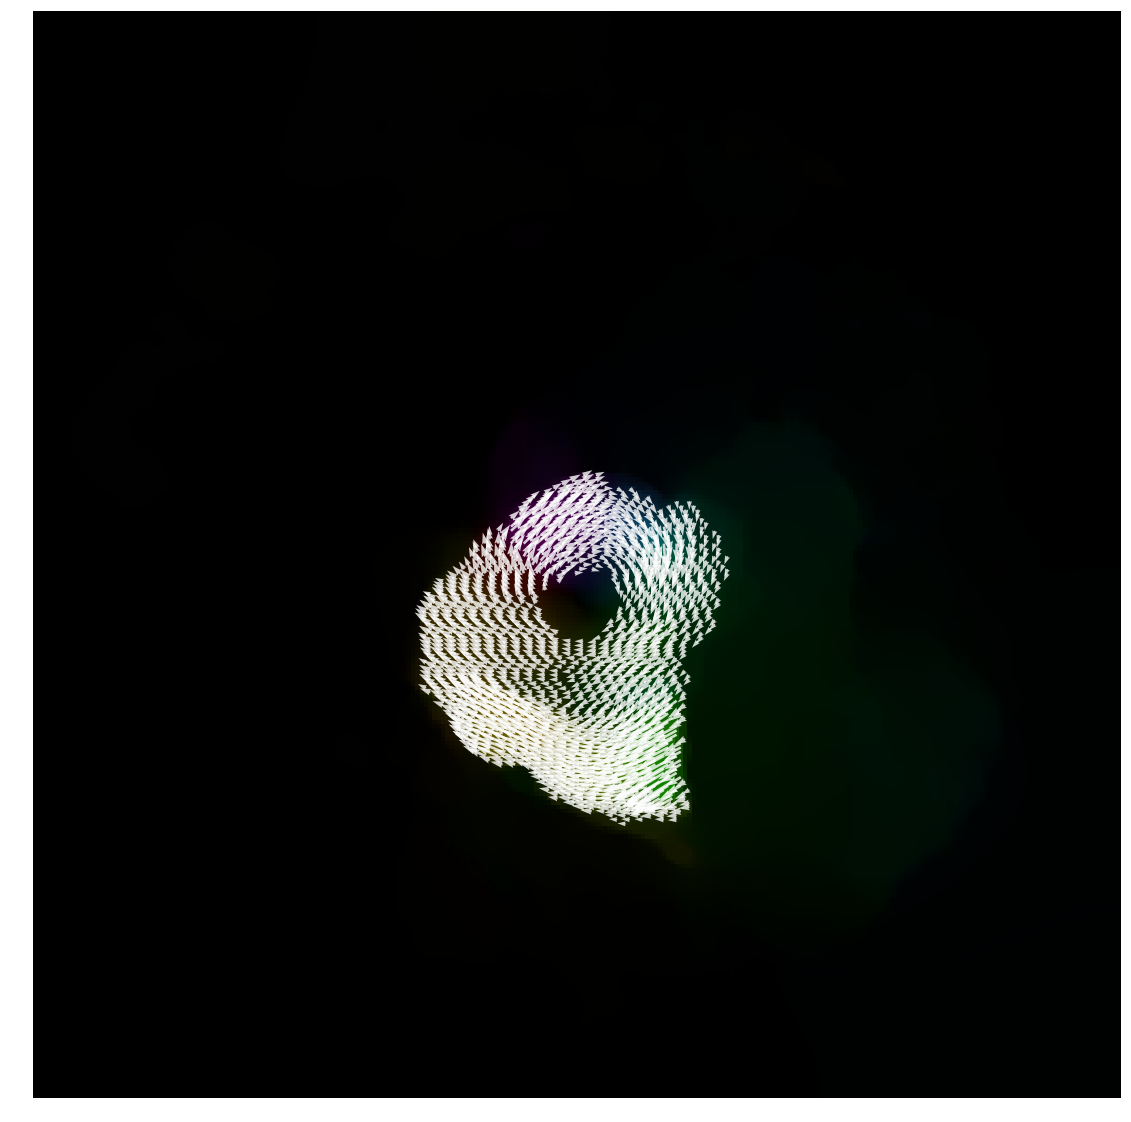

In [9]:
desc('/home/alejandra/HEART/Sunny_tesis/HEART/OF-PPM/SC-HF-I-01/7/000012.ppm',
        '/home/alejandra/HEART/Sunny_tesis/HEART/PPM/SC-HF-I-01/7/000012.ppm', 19)

15.00130101580409


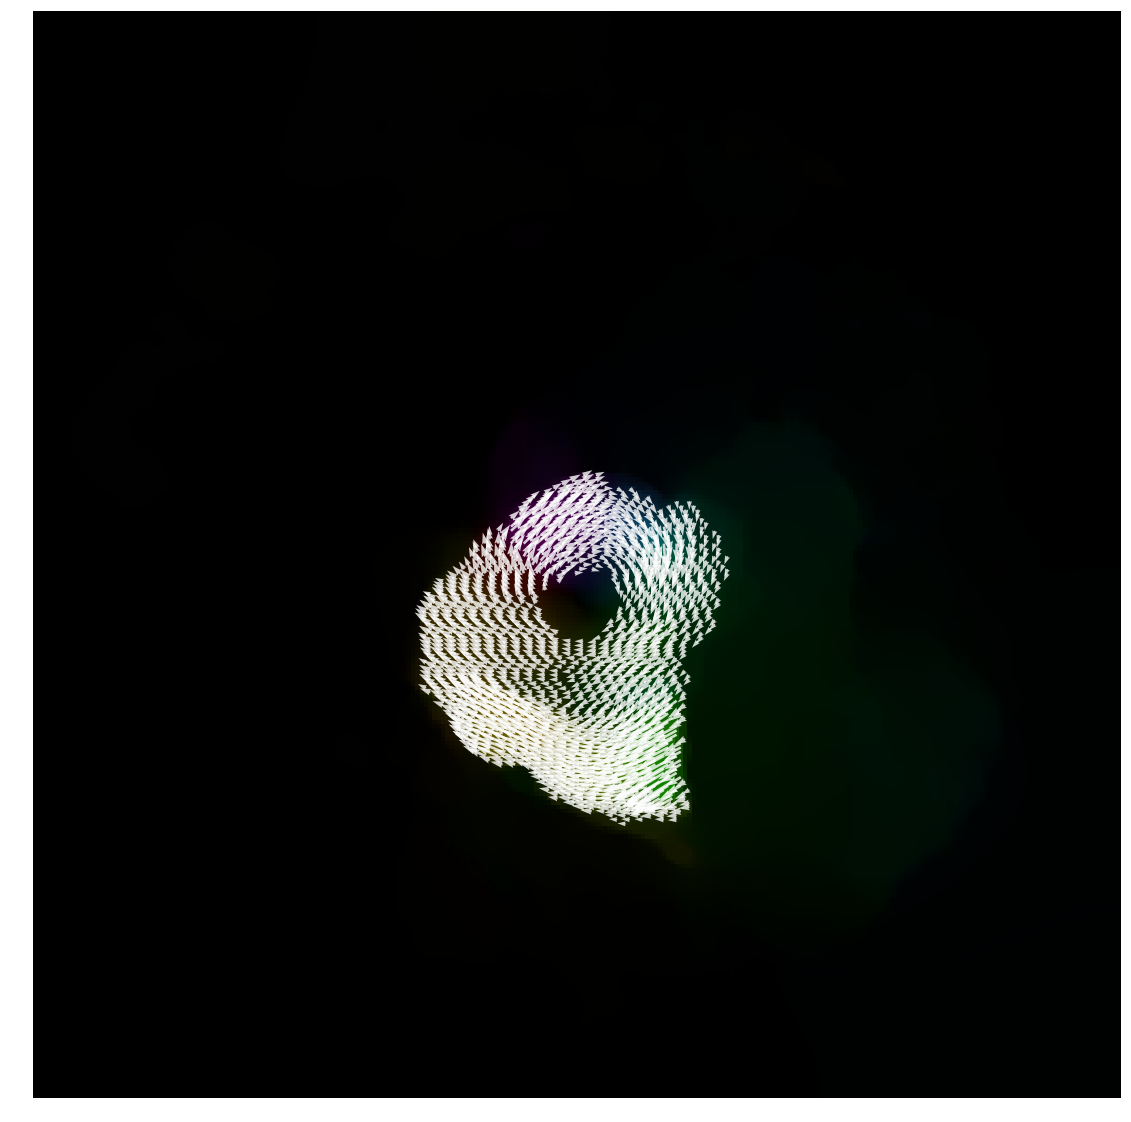

In [53]:
#desc('/home/alejandra/HEART/Sunny_tesis/HEART/OF-PPM/SC-HYP-01/4/000028.ppm',
#        '/home/alejandra/HEART/Sunny_tesis/HEART/PPM/SC-HYP-01/4/000028.ppm', 19)
desc('/home/alejandra/HEART/Sunny_tesis/HEART/OF-PPM/SC-HF-I-01/7/000012.ppm',
        '/home/alejandra/HEART/Sunny_tesis/HEART/PPM/SC-HF-I-01/7/000012.ppm', 19)
